# Derived from Geron 11_deep_learning.ipynb

We will provide a quick introduction into programming with

We revist our old friend, MNIST digit classification and provide a solution using the high-level Keras API

In [ ]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


# Set Keras backend

In [ ]:
import os
os.environ["KERAS_BACKEND"] =  "torch" # "tensorflow" # torch

import keras

print(f"Keras version {keras.__version__}, backend: {keras.backend.backend()}")


Keras version 3.8.0, backend: torch


## List version of backend

In [ ]:
if keras.backend.backend() ==  "tensorflow":
  import tensorflow as tf
  print(f"TensorFlow version {tf.__version__}")
elif keras.backend.backend() ==  "torch":
  import torch
  print(f"PyTorch version {torch.__version__}")

PyTorch version 2.6.0+cu124


# List GPU's available

In [ ]:
# prompt: depending on backend, list gpu devices available

if os.environ["KERAS_BACKEND"] == "tensorflow":
  gpu_available = tf.config.list_physical_devices('GPU')
  if gpu_available:
    print("GPU available with TensorFlow:")
    for gpu in gpu_available:
      print(f"  {gpu}")
  else:
    print("No GPU available with TensorFlow.")
elif os.environ["KERAS_BACKEND"] == "torch":
  if torch.cuda.is_available():
    print("GPU available with PyTorch:")
    device_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
    print(f"GPUs: {', '.join(device_names)}")
  else:
    print("No GPU available with PyTorch.")
else:
    print("Unknown Keras backend.")


No GPU available with PyTorch.


# Standard imports

In [ ]:
import keras

import numpy as np
import os

import pdb

from pprint import pprint

# Get the MNIST dataset
- data pre-split into training and test sets
  - flatten the images from 2 dimensional to 1 dimensional (makes it easier to feed into first layer)
  - create validation set from part of training
- "normalize" the inputs: change pixel range from [0,255] to [0,1]

In [ ]:
from re import X

# Data loading
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
print(f"Example data type: {type(X_train)}, shape{X_train[0].shape}")

# input image dimensions
img_rows, img_cols = X_train[0].shape

print(f"Example dimensions (raw input): {X_train[0].shape}")

# Flatten and normalize the data
# Determine
# - the dimensions of the input by examining the first training example
# - the dimensions of the output (number of classes) by examinimg the targets
input_size = np.prod(X_train[0].shape)
output_size = np.unique(y_train).shape[0]

X_train = X_train.reshape(-1, input_size).astype('float32') / 255
X_test = X_test.reshape(-1, input_size).astype('float32') / 255




Example data type: <class 'numpy.ndarray'>, shape(28, 28)
Example dimensions (raw input): (28, 28)


In [ ]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [ ]:
n_epochs = 20
batch_size = 50

(n_hidden_1, n_hidden_2) = (100, 30)
modelName = "mnist"


## Boiler plate

Here are some of our standard imports.



In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

from keras.utils import plot_model
import IPython


## Define the model

A `Sequential` model can be created either
- with an explicit `Input(shape=input_shape)` as first layer
- where `input_shape` is the size of a *single example* (without batch dimension)

Alternatively, the model can be defined without  an explicit `Input(shape=input_shape)`

When this occurs, the size of the input will be either
- inferred by the size of the first example passed to it
- OR by calling the `build` method with the input size
  - **Note** the argument to build should have a batch dimension of None
  - contrast this with the `shape` argument of `Input`
    - **no** batch dimension


In [ ]:
# Model definition
model = Sequential([
    Dense(n_hidden_1, activation='relu', name="hidden_1"),
    Dense(n_hidden_2, activation='relu', name="hidden_2"),
    Dense(output_size, activation='softmax', name="outputs")
])



 # Compile the model

Below
- we will use `sparse_categorical_crossentropy` as the loss (`sparse` because our labels are not one-hot encoded).
- `adam` as our optimizer (could have easily chosen `sgd`

In [ ]:
metrics = [ "accuracy" ]

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=metrics)



# Sets all random seeds (Python, NumPy, and backend framework, e.g. TF).

We are doing this so that the execution is reproducible across runs.

In [ ]:
keras.utils.set_random_seed(42)

# Training

- Shuffle before each epoch
- We use 10% of the data as validation
  - the final 10% (before shuffling)


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=128,
                    shuffle=True,
                    validation_split=0.1)



Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7748 - loss: 0.7740 - val_accuracy: 0.9565 - val_loss: 0.1664
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9458 - loss: 0.1898 - val_accuracy: 0.9677 - val_loss: 0.1239
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9601 - loss: 0.1349 - val_accuracy: 0.9708 - val_loss: 0.1042
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9695 - loss: 0.1041 - val_accuracy: 0.9723 - val_loss: 0.1017
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9753 - loss: 0.0826 - val_accuracy: 0.9742 - val_loss: 0.0947


In [ ]:
# Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest accuracy: {test_acc:.4f}')


Test accuracy: 0.9705


## Utilities


In [ ]:
# prompt: create a function "plot_training" that takes the output of model.fit and plots the metrics

import matplotlib.pyplot as plt

def plot_training(history):
    """
    Plots the training and validation metrics from a Keras History object.

    Args:
        history: The History object returned by model.fit().
    """
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


## History and callbacks

Strictly speaking, the next few cells are not absolutely necessary: they go far beyond what our layers program accomplishes
- call backs
  - these are functions that are called automatically in the training loop
    - `EarlyStopping`is a call back that will terminate the training loop when it is no longer productive to continue (e.g., when validation loss levels off)
    - `ModelCheckpoint` is a call back that will create intermediate snapshots of our model (including the parameters/weights it has learned)
      - We will create a checkpoint whenever accuracy improves.  So if further training reduces accuracy, we can restore back to the "best" parameter values.
      - This means we can re-start the model and continue to train without losing the "best" values.
      - In the layers code, we only created a single checkpoint at the end of training
  

### Create call backs
- Early Stopping
- Model Checkpoint

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es_callback = EarlyStopping(monitor='val_loss', min_delta=.00005,
                            patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

modelName = "mnist_first"
callbacks = [ es_callback,
              ModelCheckpoint(filepath=modelName + "_ckpt" + ".keras", monitor='val_accuracy', mode='max', save_best_only=True)
          ]

## Training statistics

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

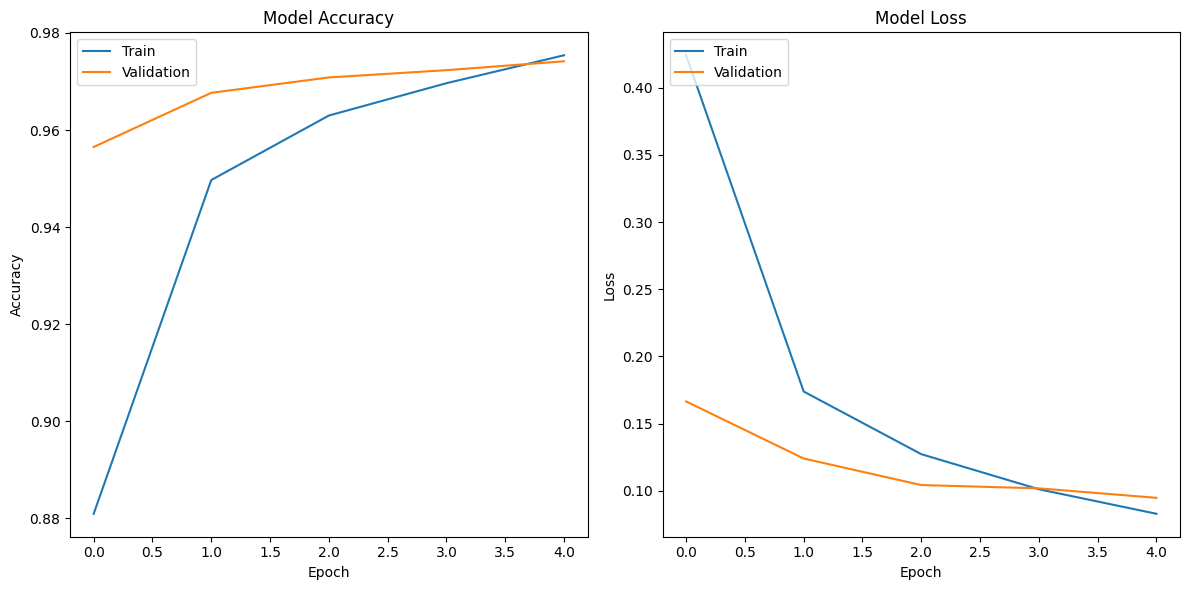

In [ ]:
plot_training(history)

## Use the model for prediction

Just as with `sklearn`, once we have fit the model, we can use the `predict` method to map inputs to predictions.
- Remember: the `outputs` layer has 10 elements, one per output class (so it is one-hot encoded)

In [ ]:
predictions = model.predict(X_test)
predictions.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(10000, 10)

## Examine the model

Observe the number of parameters (weights) that the model requires.  Is it larger than you thought ?

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (128, 100)             │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (128, 30)              │         3,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (128, 10)              │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,522 (959.07 KB)

 Trainable params: 81,840 (319.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 163,682 (639.38 KB)

## Bonus: Visualize the model's layers !

- if the model does not have an explicit `Input` layer
  - the shapes of the layer inputs and outputs will be unknown
  - until either
    - the `build` method is called on the model, passing in the `input_shape`
    - the model is called the first time
      - which implicittly creates an `Input` layer
      - the shape of the inputs of the first example becme the `input_shape`


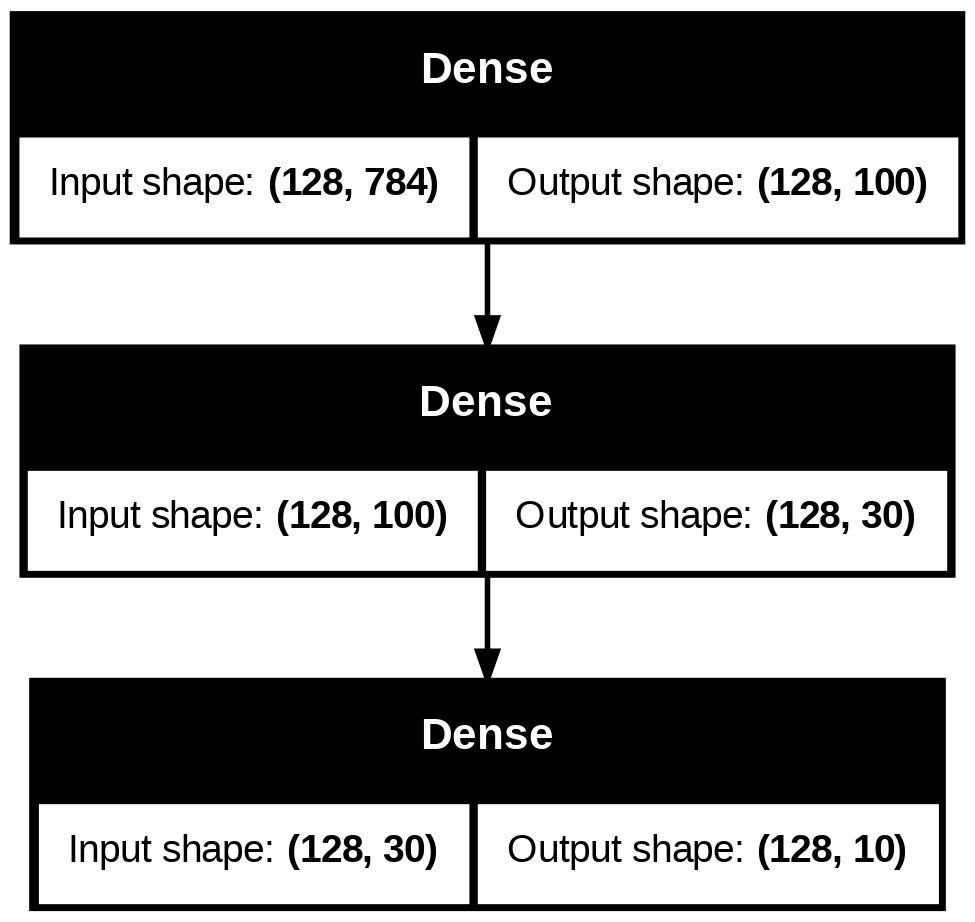

In [ ]:
plot_model(model, "mnist_model.png", show_shapes=True)
IPython.display.Image(  "mnist_model.png")

# Saving and reloading a model

## Save the model (architecture + weights + optimizer state)

In [ ]:
# prompt: save the model using Keras 3 in a backend agnostic format

model_dir = modelName + ".keras"

# The backend-agnostic Keras format (ending in .keras) does not save the optimizer state.
model.save(model_dir)
print(f"Model saved to {modelName}.keras")

Model saved to mnist_first.keras


## Load a saved model

In [ ]:
load_model = keras.models.load_model(model_dir)

### Show that the restored model works

In [ ]:
load_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (128, 100)             │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (128, 30)              │         3,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (128, 10)              │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,522 (959.07 KB)

 Trainable params: 81,840 (319.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 163,682 (639.38 KB)

In [ ]:
predictions_orig = model.predict(X_test)
predictions_orig.shape

predictions_restored = load_model.predict(X_test)
predictions_restored.shape

all_match = np.all(predictions_orig == predictions_restored)
if all_match:
  answer = "YES"
else:
  answer = "NO"

print("Live model and restore model results match ?", answer)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Live model and restore model results match ? YES


# Hyper-parameter search: Keras tuner

How many units should be in my non-head `Dense` layers ?
- You can experiment by hand
- You can make the number of units a *hyper-paramter* and have Keras search for the best value

**The Tuner is VERY SLOW without a GPU**
- I highly recommend using a GPU on this section

In [ ]:
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/NYU/demo"

  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)

  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
else:
    raise RuntimeError("This notebook should be run from Colab, not on the local machine")

Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Colab: making sure  /content/gdrive/My Drive/Colab Notebooks/NYU/demo  exists.

Colab: Changing directory to  /content/gdrive/My Drive/Colab Notebooks/NYU/demo
/content/gdrive/My Drive/Colab Notebooks/NYU/demo


In [ ]:
# Change to demo directory so tuner-related output files are saved in common place
if IN_COLAB:
  import os
  kt_demo_dir = os.path.join(drive_root, "Keras_tuner")
  %cd $kt_demo_dir

/content/gdrive/My Drive/Colab Notebooks/NYU/demo/Keras_tuner


In [ ]:
# Make sure necessary packages are present

import pkg_resources
import sys
import subprocess

required = {'keras_tuner'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    rc = subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

    if rc == 0:
      print("Installed: ", ", ".join( list(missing) ) )

Installed:  keras_tuner


## Here is the tuning code

In [ ]:
# You may need to `pip install keras-tuner` before running the import

import keras_tuner as kt

### Create the model, using a place-holder for each hyperparameter

In [ ]:
def build_model(hp):

    ## Tunable hyperparameters
    hp_dropout1_units = hp.Float("dropout_1", min_value=0., max_value=0.9, step=0.3)
    hp_dropout2_units = hp.Float("dropout_2", min_value=0., max_value=0.9, step=0.3)

    hp_dense1_units = hp.Int("dense_1", min_value=8, max_value=24, step=8)
    hp_dense2_units = hp.Int("dense_2", min_value=8, max_value=24, step=8)

    ## Tune the learning rate for the optimizer
    ## Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate)

    # The model
    model = keras.Sequential()

    model.add(Input(shape=(input_size,)))

    # Block 1: Dropout + Dense
    model.add(Dense( hp_dense1_units, activation="relu") )
    model.add(Dropout( hp_dropout1_units ) )

    # Block 2: Dropout + Dense
    model.add(Dense( hp_dense2_units, activation="relu" ) )
    model.add(Dropout( hp_dropout2_units ) )

    # Head layer
    model.add(Dense(output_size,
                    activation=keras.activations.softmax) )

    model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=optimizer)

    return model

### Search for the optimal values for the hyperparameters

In [ ]:
## HyperBand algorithm from keras tuner
overwrite_results=True # Set to False if you want to RE-USE results of previously run search

tuner = kt.Hyperband(build_model, objective='val_accuracy',
    max_epochs=10,
    directory='keras_tuner_dir', project_name='dnn_keras_tuner_demo',
    overwrite=overwrite_results)

# tuner.search(X_train, y_train, epochs=50, validation_split=0.1)
tuner.search(X_train, y_train, epochs=n_epochs,
             batch_size=batch_size,
             validation_split=0.1,
             shuffle=True,
             callbacks=callbacks)


Trial 24 Complete [00h 00m 33s]
val_accuracy: 0.8044999837875366

Best val_accuracy So Far: 0.9506666660308838
Total elapsed time: 00h 09m 32s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
0.3               |0                 |dropout_1
0.6               |0                 |dropout_2
8                 |16                |dense_1
8                 |8                 |dense_2
0.0026207         |0.00034114        |learning_rate
10                |10                |tuner/epochs
4                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
1                 |2                 |tuner/round
0023              |0012              |tuner/trial_id

Epoch 5/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3988 - loss: 1.6569 - val_accuracy: 0.7930 - val_loss: 1.0477
Epoch 6/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4026 - loss: 1.6389 - val_accuracy: 0.8107 - val_loss: 1.0043
Epoch 7/10


KeyboardInterrupt: 

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build()
best_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,786 (49.95 KB)

 Trainable params: 12,786 (49.95 KB)

 Non-trainable params: 0 (0.00 B)

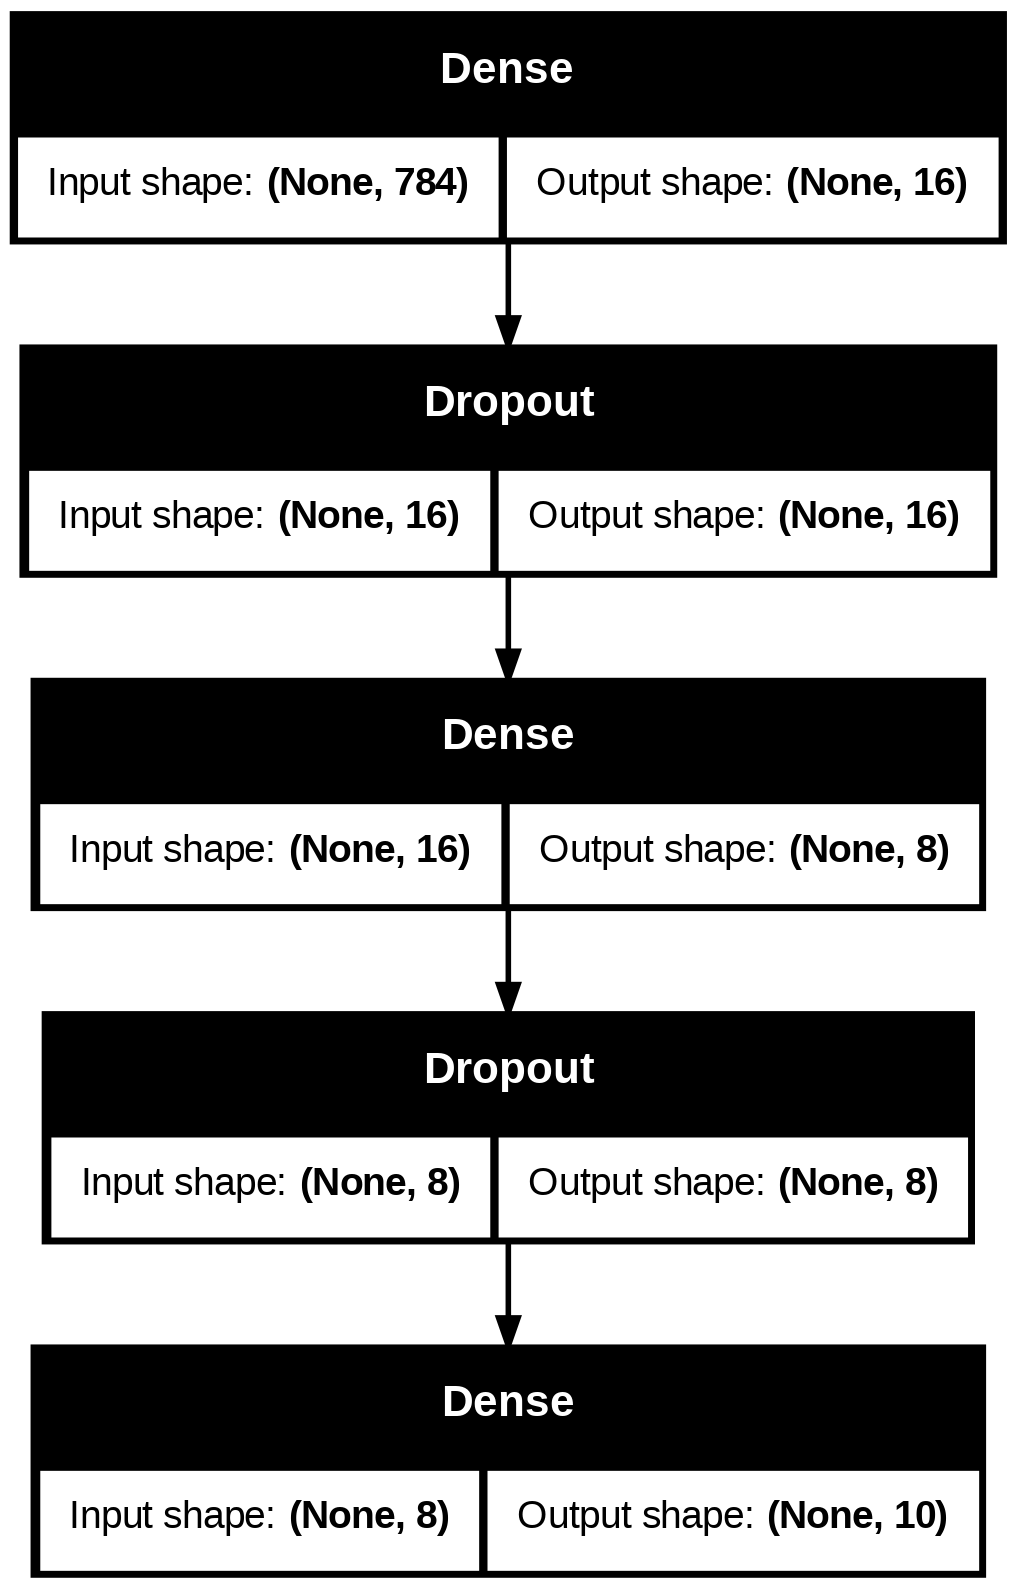

In [ ]:
plot_model(best_model, show_shapes=True)

## Find the values of the hyperparameters for the top trials

In [ ]:
best_hps = tuner.get_best_hyperparameters(2)

In [ ]:
print("Best hyper parameter values:")
pprint( best_hps[0].values )



Best hyper parameter values:
{'dense_1': 16,
 'dense_2': 8,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'learning_rate': 0.00034113846912856477,
 'tuner/bracket': 2,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}


In [ ]:
print("Second Best hyper parameter values:")
pprint( best_hps[1].values )


Second Best hyper parameter values:
{'dense_1': 16,
 'dense_2': 8,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'learning_rate': 0.00034113846912856477,
 'tuner/bracket': 2,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0006'}


In [ ]:
print("Best hyper parameter values:")
best_hps[0].values



Best hyper parameter values:


{'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dense_1': 16,
 'dense_2': 8,
 'learning_rate': 0.00034113846912856477,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}

In [ ]:
print("Second Best hyper parameter values:")
best_hps[1].values


Second Best hyper parameter values:


{'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dense_1': 16,
 'dense_2': 8,
 'learning_rate': 0.00034113846912856477,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0006'}

In [ ]:
tuner.results_summary(num_trials=2)

Results summary
Results in keras_tuner_dir/dnn_keras_tuner_demo
Showing 2 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
dropout_1: 0.0
dropout_2: 0.0
dense_1: 16
dense_2: 8
learning_rate: 0.00034113846912856477
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.9506666660308838

Trial 0012 summary
Hyperparameters:
dropout_1: 0.0
dropout_2: 0.0
dense_1: 16
dense_2: 8
learning_rate: 0.00034113846912856477
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0006
Score: 0.9358333349227905


In [ ]:
historyX = best_model.fit(X_train, y_train, epochs=n_epochs,
                          batch_size=batch_size,
                          validation_split=0.1,
                          shuffle=True,
                          callbacks=callbacks)


Epoch 1/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9428 - loss: 0.2054 - val_accuracy: 0.9503 - val_loss: 0.1820
Epoch 2/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9454 - loss: 0.1963 - val_accuracy: 0.9517 - val_loss: 0.1819
Epoch 3/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9460 - loss: 0.1915 - val_accuracy: 0.9510 - val_loss: 0.1790
Epoch 4/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9456 - loss: 0.1942 - val_accuracy: 0.9530 - val_loss: 0.1775
Epoch 5/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9490 - loss: 0.1828 - val_accuracy: 0.9533 - val_loss: 0.1718
Epoch 6/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9494 - loss: 0.1834 - val_accuracy: 0.9548 - val_loss: 0.1707
Epoch 7/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9501 - loss: 0.1775 - val_accuracy: 0.9510 - val_loss: 0.1738
Epoch 8/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9499 - loss: 0.1719 

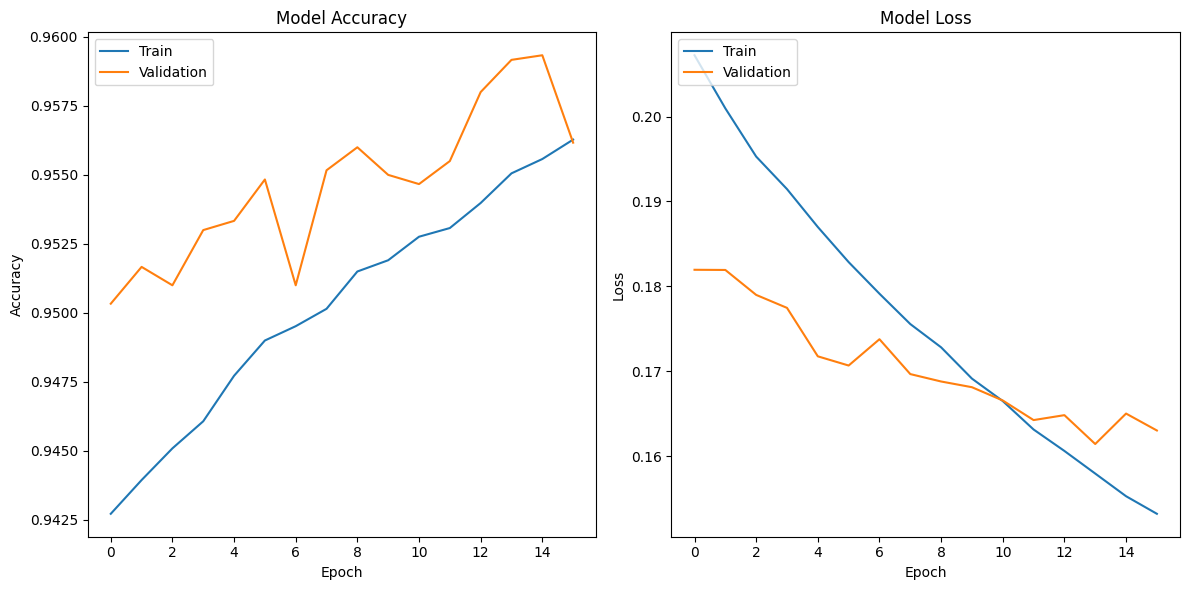

In [ ]:
_= plot_training( historyX )

In [ ]:
print("Done")

Done
